### Q10

In [29]:
import numpy as np
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
from tqdm import tqdm

In [30]:
# loading data
train_x, train_y = load_svmlight_file('madelon')
test_x, test_y= load_svmlight_file('madelon.t')

train_x = train_x.toarray()
test_x = test_x.toarray()

In [31]:
# Decision Stump Implementation
def decision_stump_fit(X, y, weights):
    n_samples, n_features = X.shape
    best_feature = None
    best_threshold = None
    best_polarity = 1
    min_error = float('inf')

    for feature_i in range(n_features):
        thresholds = np.unique(X[:, feature_i])
        for threshold in thresholds:
            for polarity in [1, -1]:

                predictions = np.ones(n_samples)
                predictions[polarity * X[:, feature_i] < polarity * threshold] = -1

                error = np.sum(weights[y != predictions])
                if error < min_error:
                    min_error = error
                    best_feature = feature_i
                    best_threshold = threshold
                    best_polarity = polarity

    return best_feature, best_threshold, best_polarity, min_error

def decision_stump_predict(X, feature, threshold, polarity):
    n_samples = X.shape[0]
    predictions = np.ones(n_samples)
    predictions[polarity * X[:, feature] < polarity * threshold] = -1
    return predictions


In [32]:
# AdaBoost Implementation
def adaboost_fit(X, y, n_iterations=500):
    n_samples = X.shape[0]
    weights = np.ones(n_samples) / n_samples
    classifiers = []

    alphas = []
    errors = []

    for t in range(n_iterations):
        feature, threshold, polarity, error = decision_stump_fit(X, y, weights)

        alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
        predictions = decision_stump_predict(X, feature, threshold, polarity)

        weights *= np.exp(-alpha * y * predictions)
        weights /= np.sum(weights)

        classifiers.append((feature, threshold, polarity, alpha))
        alphas.append(alpha)
        errors.append(error)

    return classifiers, alphas, errors

In [33]:
# Prediction
def adaboost_predict(X, classifiers):
    n_samples = X.shape[0]
    final_predictions = np.zeros(n_samples)

    for feature, threshold, polarity, alpha in classifiers:
        predictions = decision_stump_predict(X, feature, threshold, polarity)
        final_predictions += alpha * predictions

    return np.sign(final_predictions)



In [34]:
n_iterations = 500
classifiers, alphas, errors = adaboost_fit(train_x, train_y, n_iterations)

In [36]:
y_train_pred = adaboost_predict(train_x, classifiers)
y_test_pred = adaboost_predict(test_x, classifiers)

E_in = np.mean(train_y != y_train_pred)
E_out = np.mean(test_y != y_test_pred)

print(f"E_in: {E_in}, E_out: {E_out}")

E_in: 0.041, E_out: 0.3933333333333333


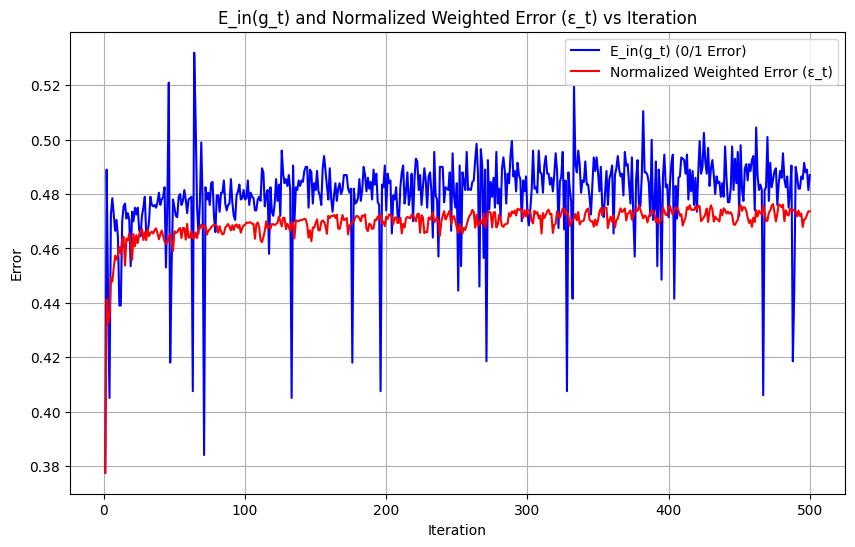

In [38]:
# plotting
def plot_errors(X_train, y_train, classifiers, errors, n_iterations):
    ein_list = []  
    
    for t in range(n_iterations):

        feature, threshold, polarity, alpha = classifiers[t]
        predictions = decision_stump_predict(X_train, feature, threshold, polarity)
        ein = np.mean(y_train != predictions)  
        ein_list.append(ein)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_iterations + 1), ein_list, label="E_in(g_t) (0/1 Error)", color="blue")
    plt.plot(range(1, n_iterations + 1), errors, label="Normalized Weighted Error (ε_t)", color="red")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.title("E_in(g_t) and Normalized Weighted Error (ε_t) vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_errors(train_x, train_y, classifiers, errors, n_iterations)


### Q11

In [39]:
def calculate_ensemble_errors(X_train, y_train, X_test, y_test, classifiers, n_iterations):
    E_in_G = [] 
    E_out_G = []  

    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    G_train = np.zeros(n_train)
    G_test = np.zeros(n_test)

    for t in range(n_iterations):
        
        feature, threshold, polarity, alpha = classifiers[t]
        G_train += alpha * decision_stump_predict(X_train, feature, threshold, polarity)
        G_test += alpha * decision_stump_predict(X_test, feature, threshold, polarity)

        y_train_pred = np.sign(G_train)
        y_test_pred = np.sign(G_test)

        E_in_G.append(np.mean(y_train_pred != y_train))
        E_out_G.append(np.mean(y_test_pred != y_test))

    return E_in_G, E_out_G

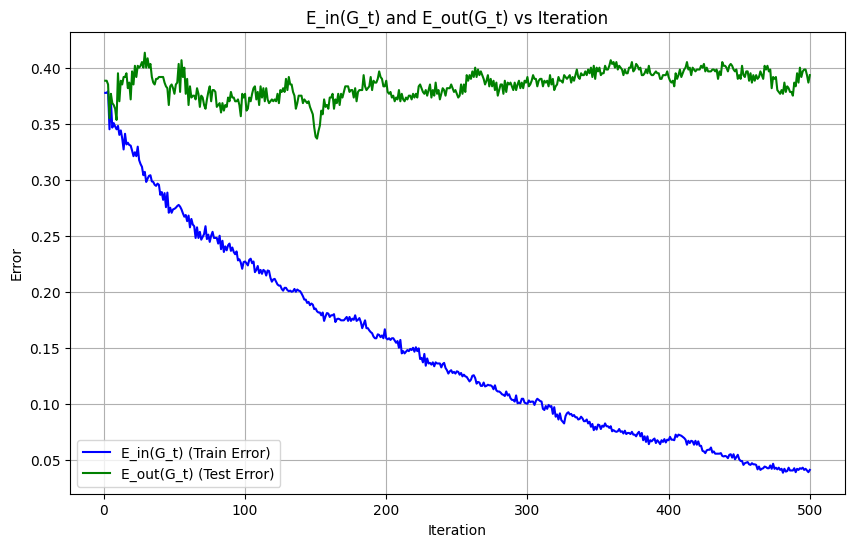

In [41]:
E_in_G, E_out_G = calculate_ensemble_errors(train_x, train_y, test_x, test_y, classifiers, n_iterations)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), E_in_G, label="E_in(G_t) (Train Error)", color="blue")
plt.plot(range(1, n_iterations + 1), E_out_G, label="E_out(G_t) (Test Error)", color="green")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("E_in(G_t) and E_out(G_t) vs Iteration")
plt.legend()
plt.grid(True)
plt.show()

### Q12

In [42]:
def calculate_u_t_from_theory(errors, n_iterations):
    U_t = [1.0]  
    for t in range(n_iterations):
        epsilon_t = errors[t]
        U_t.append(U_t[-1] * 2 * np.sqrt(epsilon_t * (1 - epsilon_t)))  
    return U_t[1:]  

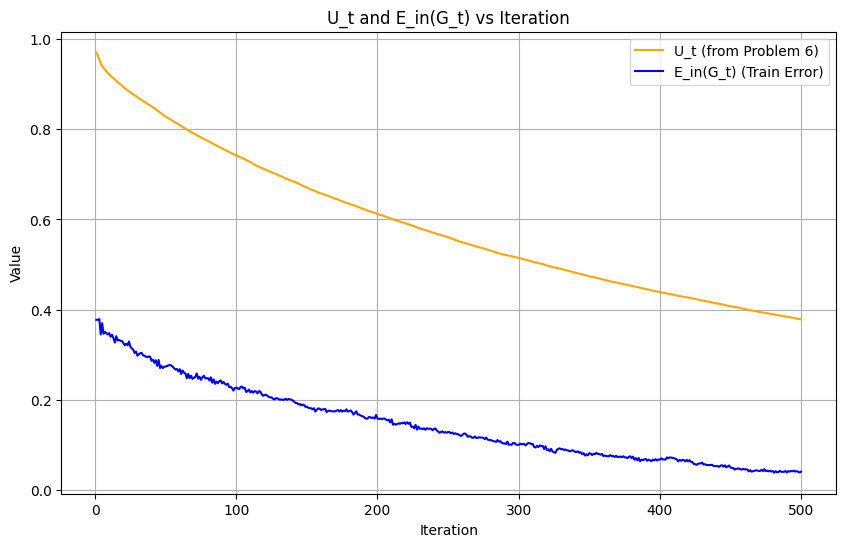

In [43]:
U_t = calculate_u_t_from_theory(errors, n_iterations)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), U_t, label="U_t (from Problem 6)", color="orange")
plt.plot(range(1, n_iterations + 1), E_in_G, label="E_in(G_t) (Train Error)", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("U_t and E_in(G_t) vs Iteration")
plt.legend()
plt.grid(True)
plt.show()
